## BBM409 Introduction to Machine Learning Lab.  Fall 2022.
# Assignment 2: PART 1 :  Employee Attrition Prediction

# TODO:

* # <s>"used_attributes" ile ilgili yazdığım comment'i oku.
* acıklamalar detaylandırılmalı
* cross validation scorelardan düzgün bir şekilde df oluşturup, farklı decision_tree variationlarının performansını göstermeliyiz, computation time da mention edilmeli
* Question.match() de hic görülmemis bir labella karsilarirsa, column ortalaması kullanılabilirmiş. öncelik sırası az ama bence - https://stats.stackexchange.com/questions/96025/how-do-decision-tree-learning-algorithms-deal-with-missing-values-under-the-hoo
</s>
* few missclassifiedlar üzerine yorum.
*


### Contributors:

### Ali Argun Sayilgan   : 21827775
### Mehmet Giray Nacakci :  21989009

## Please run this report with   "RUN ALL" command


# Dataset

The dataset consists of past and current employees of a company in a spreadsheet. It has 35 data points for the employees, including the ground truth label(attrition). At this assignment, we will be investigating how other attributes of the employees' relates to workforce attrition using decision tree ML model.

Education <br /> 1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor'

EnvironmentSatisfaction, JobInvolvement, JobSatisfaction, RelationshipSatisfaction <br />
1 'Low' 2 'Medium' 3 'High' 4 'Very High'

PerformanceRating  <br />
1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'

WorkLifeBalance <br />
1 'Bad' 2 'Good' 3 'Better' 4 'Best'

In [413]:
import pandas as pd
import numpy as np
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
pd.options.display.max_columns = len(df.columns)
pd.set_option('display.precision', 6)
header = df.drop(['Attrition'], axis=1).columns
ground_truth_label = "Attrition"
ground_truth_classes = df.Attrition.unique()

df.describe(include = 'all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.0,1470.000000,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,Y,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,NaN,961,NaN,NaN,606,NaN,NaN,NaN,882,NaN,NaN,NaN,326,NaN,673,NaN,NaN,NaN,1470,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,802.485714,NaN,9.192517,2.912925,NaN,1.0,1024.865306,2.721769,NaN,65.891156,2.729932,2.063946,NaN,2.728571,NaN,6502.931293,14313.103401,2.693197,NaN,NaN,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,403.509100,NaN,8.106864,1.024165,NaN,0.0,602.024335,1.093082,NaN,20.329428,0.711561,1.106940,NaN,1.102846,NaN,4707.956783,7117.786044,2.498009,NaN,NaN,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2094.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,465.000000,NaN,2.000000,2.000000,NaN,1.0,491.250000,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2911.000000,8047.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,802.000000,NaN,7.000000,3.000000,NaN,1.0,1020.500000,3.000000,NaN,66.000000,3.000000,2.000000,NaN,3.000000,NaN,4919.000000,14235.500000,2.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,1157.000000,NaN,14.000000,4.000000,NaN,1.0,1555.750000,4.000000,NaN,83.750000,3.000000,3.000000,NaN,4.000000,NaN,8379.000000,20461.500000,4.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


## Number of occurences of class types


In [414]:
df.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

# Preprocessing

As can seen, there's an inbalance for ground truth labels at the dataset.

In this project we prefer not to do any additional preproccessing steps.

To train decision tree model, we must split the dataset into X(employee's attributes) and y(attrition status Yes/No).

In [415]:
X = df.drop(['Attrition'], axis=1)
y = df.Attrition
mode_of_each_column = X.mode().iloc[0].to_list()

X = X.to_numpy()
Y = y.to_numpy()

# ML model performance evaluation methods
### Confusion matrix
Confusion matrix is an N x N matrix used for evaluating the performance of a classification model. It is extremely useful for measuring Recall, Precision, Specificity, Accuracy, and AUC-ROC curves.

In [416]:
def accuracy(preds, labels):
    """Calculates accuracy given two numpy arrays"""
    return np.mean(preds == labels)

def confusion_matrix(preds, labels, num_of_labels):
    """Creates a confusion matrix from given two numpy arrays"""
    unique_label_classes = np.sort(np.unique(labels)) 
    int_encoded_labels = np.searchsorted(unique_label_classes,labels)
    int_encoded_pred = np.searchsorted(unique_label_classes,preds)

    matrix = np.zeros((num_of_labels,num_of_labels))
    for i in range(len(preds)):
        matrix[int_encoded_pred[i],int_encoded_labels[i]] += 1
    return matrix    

def precision_and_recall(preds, labels):
    """Returns individual Precision and Recall values of each class"""
    num_of_labels = len(np.unique(labels))
    matrix = confusion_matrix(preds, labels, num_of_labels)
    r = []
    p = []
        
    number_of_not_NA_precision, number_of_not_NA_recall, precision_sum, recall_sum = 0, 0, 0, 0

    for i in range(num_of_labels):
        TP = float(matrix[i,i])
        TP_FP = np.sum(matrix[i,:])
        TP_FN = np.sum(matrix[:,i])

        if TP_FN != 0:
            recall_sum += TP / TP_FN
            number_of_not_NA_recall +=1

        if TP_FP != 0:
            precision_sum += TP / TP_FP
            number_of_not_NA_precision +=1

    recall = recall_sum / number_of_not_NA_recall if number_of_not_NA_recall != 0 else "NA"
    precision = precision_sum / number_of_not_NA_precision if number_of_not_NA_precision != 0 else "NA"

    return (precision, recall)


def fscore(preds, labels):
    """Calculates macro f score given two numpy arrays"""
    pred_labels, pred_numberized = np.unique(preds, return_inverse=True)
    labels, labels_numberized = np.unique(labels, return_inverse=True)
    p, r = precision_and_recall(pred_numberized, labels_numberized)
    if p == "NA" or r == "NA" or p+r == 0:
        return "NA"

    return 2*p*r/(p+r)

## Helper functions that are used at ID3 Decision Tree Algorithm 

In [417]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [418]:
def class_counts(numpy_arr):
    """Returns the unique elements that are inside the
    numpy array, and their individual counts"""

    if len(numpy_arr.shape)==2:
        valueCounts = pd.Series(numpy_arr[:, 0]).value_counts()
        return np.array(valueCounts.keys().to_list()), np.array(valueCounts.to_list())
    else:
        valueCounts = pd.Series(numpy_arr).value_counts()
        return np.array(valueCounts.keys().to_list()), np.array(valueCounts.to_list())

In [419]:
class Question:
    """Questions are used to partition a dataset."""

    def __init__(self, column, partition_values, partition_type):
        self.column = column
        self.partition_values = partition_values
        self.partition_type = partition_type



    def match(self, row):
        """Answers question for a particular row (sample).
        Return index of which Child Branch to go."""
        
        if self.partition_type == "discrete":
            for t, val in enumerate(self.partition_values):
                if row[self.column] == val:
                    return t
            
            # if test data has a value not seen while training
            # it behaves like it's value is mode of that column
            for t, val in enumerate(self.partition_values):
                if mode_of_each_column[self.column] == val:
                    return t
            return 0



        elif self.partition_type == "interval":
            if len(self.partition_values) == 1:
                return 0

            for k in range(1,len(self.partition_values)-1):
                if self.partition_values[k-1] <= row[self.column] < self.partition_values[k]:
                    return k
            if row[self.column] >= self.partition_values[-2]:
                return len(self.partition_values)-1
            if row[self.column] < self.partition_values[0]:
                return 0


    def __repr__(self):
        """Helper method to print question in readable form"""

        if self.partition_type == "discrete":
            return "which {} category ?".format(header[self.column])

        elif self.partition_type == "interval":
            return "which {} interval ?".format(header[self.column])

        equality_condition = "=="
        if is_numeric(self.value):
            if self.partition_type == "discrete":
                return "Is {} {} {} ?".format(header[self.column], equality_condition, str(self.value))
            elif self.partition_type == "interval":
                return "Is {} at range {} ?".format(header[self.column], str(self.value))

            return "Is {} {} {} ?".format(header[self.column], equality_condition, str(self.value))



            
        return "Is {} {} {} ?".format(header[self.column], condition, str(self.value))


### Entropy

Entropy is the degree of uncertainty, impurity or disorder of a random variable, or a measure of purity. It characterizes the impurity of an arbitrary class of examples. 

It can be calculated as shown in the figure below. i denotes each ground truth label.

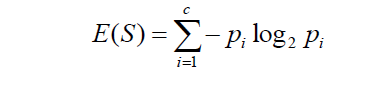

In [420]:
def entropy(Y):
    """Calculate entropy of data from labels"""
    labels, counts = class_counts(Y)
    probs = counts / float(Y.shape[0])
    entropy = - np.sum(probs * np.log2(probs))
    return entropy

### Information Gain

<b>Information Gain = Entropy before splitting - Entropy after splitting</b>


The concept of entropy plays an important role in measuring the information gain. However, “Information gain is based on the information theory”.

It is used for determining the best features/attributes that render maximum information about a class. It follows the concept of entropy while aiming at decreasing the level of entropy, beginning from the root node to the leaf nodes. Information gain computes the difference between entropy before and after split and specifies the impurity in class elements. 


In [421]:
def information_gain(y, intervals_indexes, current_entropy):
    """Information Gain:  The Entropy of the starting node, minus the weighted entropy of child nodes. """
    sum_ = 0
    len_sum = 0

    # weighted sum of entropies of each split (or interval)
    for interval_indices in intervals_indexes:

        sum_ += float( len(interval_indices) * entropy(y[interval_indices]) )
        len_sum += len(interval_indices)

    return current_entropy - sum_ / len_sum


# Decision Tree ML Model

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.<br /><br />
Decision Tree models are created using 2 steps: <u>induction and pruning</u>. Induction is where we actually build the tree i.e set all of the hierarchical decision boundaries based on our data. Because of the nature of training decision trees they can be prone to major overfitting. Pruning is the process of removing the unnecessary structure from a decision tree, effectively reducing the complexity to combat overfitting with the added bonus of making it even easier to interpret.

## ID3 Decision Tree Algorithm

ID3 stands for Iterative Dichotomiser 3 and is named such because the algorithm iteratively (repeatedly) dichotomizes(divides) features into two or more groups at each step.

* It uses a top-down greedy approach to build a decision tree. The top-down approach, means that it starts building the tree from the top and the greedy means that at each iteration it selects the best feature at the present moment to create a node.

* The inductive bias in ID3 includes a preference for smaller trees.

* ID3 uses Information Gain to find the best feature.Information Gain calculates the reduction in the entropy and measures how well a given feature separates or classifies the target classes. The feature with the highest Information Gain is selected as the best one.

* Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalize to unseen data.

* ID3 does not guarantee an optimal solution. It can converge upon local optima.


* Most generally it is only used for classification problems with nominal features only. Nominal data is a type of data that is used to label variables without providing any quantitative value.

* There are different splitting methods. Multi-way split uses as many partitions as distinct values. Whereas binary split divides values into two subsets. When multi-way splitting continous data, you can prefer to split the data into intervals to make algorithm more performant.

```
ID3 (Examples, Target_Attribute, Attributes)
    Create a root node for the tree
    If all examples are positive, Return the single-node tree Root, with label = +.
    If all examples are negative, Return the single-node tree Root, with label = -.
    If number of predicting attributes is empty, then Return the single node tree Root,
    with label = most common value of the target attribute in the examples.
    Otherwise Begin
        A ← The Attribute that best classifies examples.
        Decision Tree attribute for Root = A.
        For each possible value, vi, of A,
            Add a new tree branch below Root, corresponding to the test A = vi.
            Let Examples(vi) be the subset of examples that have the value vi for A
            If Examples(vi) is empty
                Then below this new branch add a leaf node with label = most common target value in the examples
            Else below this new branch add the subtree ID3 (Examples(vi), Target_Attribute, Attributes – {A})
    End
    Return Root
```



In [422]:
class Node:
    """ Holds a reference to the question, and the child nodes that is partitioned by the question. """
    def __init__(self, child_branches, question):
        self.child_branches = child_branches
        self.question = question
        # self.answer = answer


In [423]:
class Leaf:
    """
    Leaf node contains a dictionary of counts of classes.
    Output is usually the majority class.
    """
    def __init__(self, y):
        counts = np.column_stack(class_counts(y))
        self.predictions = {row[0]:row[1] for row in counts}
        # self.answer = answer


In [424]:
class Decision_Tree:

    def __init__(self, maximum_depth):
        self.depth = maximum_depth


    def train(self, X_train, y_train):
        self.root = self._build_tree(X_train, y_train, self.depth, [])
    

    def find_best_split(self, X, y, used_attributes):
        """
        Find the best question to ask by iterating over every feature.
        Choose the best possible attribute and best possible split in terms of information gain.

        Find: at which exact value or interval of which attribute we should split.
        How many intervals (branches) we want to create for this attribute (column)?
        """
        copy_used_attributes = used_attributes[0:]
        best_gain = 0  
        best_question = None
        best_partition = []
        used_attribute = 0
        current_entropy = entropy(y)
        n_features = X.shape[1]  

        for col in range(n_features):
            if col in copy_used_attributes:
                continue

            # if this column is a continuous attribute: it needs Discretization
            if is_numeric(X[0,col]):

                this_column = X[:,col]
                min_ = np.min(this_column)
                max_ = np.max(this_column)

                # rarely, but in the case that all values are same:
                if min_ == max_:  # no split (so-called split into only one branch, not two.)
                    partition_to_indexesOfSamples = [X[:, col] <= max_]
                    gain = information_gain(y, partition_to_indexesOfSamples, current_entropy)
                    if gain >= best_gain:
                        best_gain = gain
                        best_partition = partition_to_indexesOfSamples
                        best_question = Question(col, [min_], "interval")
                        used_attribute = col

                else:
                    # find best number of splits in terms of information gain
                    for n_splits in range(2,10):
                        interval_size = (max_ - min_)/n_splits

                        range_values = []
                        partitions_to_indexesOfSamples = []

                        # create partitions (intervals)
                        # n_split = n many intervals
                        for m in range(n_splits):

                            range_values.append(min_ + (m+1)*interval_size)
                            indexes_in_this_interval = []

                            if m == 0:
                                indexes_in_this_interval = X[:, col] < min_ + interval_size
                            elif m == n_splits-1:
                                indexes_in_this_interval = X[:, col] >= min_ + m * interval_size
                            else:
                                indexes_in_this_interval = filter_interval(X, col, min_, m, interval_size)

                            partitions_to_indexesOfSamples.append(indexes_in_this_interval)


                        """ Do not choose such partitioning that some empty tree branches will be created. """

                        empty_interval_alert = False

                        for indexes_in_this_interval in partitions_to_indexesOfSamples:
                            if len(indexes_in_this_interval) < 1:
                                empty_interval_alert = True
                                break

                        # skip the current n_split value. n_split many intervals is not what we are looking for.
                        if empty_interval_alert:
                            continue

                        # for n_splits, calculate information gain
                        gain = information_gain(y, partitions_to_indexesOfSamples, current_entropy)
                        if gain >= best_gain:
                            best_gain = gain
                            best_partition = partitions_to_indexesOfSamples
                            best_question = Question(col, range_values, "interval")
                            used_attribute = col


            # this column is a discrete attribute
            else:
                # multi-way split: as many branches as len(unique_values)
                unique_values = np.unique(X[:,col])
                partitions_to_indexesOfSamples = []

                for value in unique_values:
                    indexes_in_this_partition = X[:, col] == value
                    partitions_to_indexesOfSamples.append(indexes_in_this_partition)

                gain = information_gain(y, partitions_to_indexesOfSamples, current_entropy)
                if gain >= best_gain:
                    best_gain = gain
                    best_partition = partitions_to_indexesOfSamples
                    best_question = Question(col, unique_values, "discrete")
                    used_attribute = col

        copy_used_attributes.append(used_attribute)
        return best_gain, best_partition, best_question, copy_used_attributes


        
    def _build_tree(self, X_train, y_train, depth, used_attributes):
        """ recursive decision tree building function """

        if X_train.shape[0] < 2:
            return Leaf(y_train)

        if depth < 1:
            return Leaf(y_train)


        all_samples_in_subset_are_same_label = np.all(y_train == y_train[0])
        if all_samples_in_subset_are_same_label:
            return Leaf(y_train)


        gain, partitions, question, used_attributes = self.find_best_split(X_train, y_train, used_attributes)

        if gain == 0 or question is None:
            return Leaf(y_train)


        child_branches = []
        for indices_in_this_partition in partitions:
            child_branches.append( self._build_tree(X_train[indices_in_this_partition], y_train[indices_in_this_partition], depth-1, used_attributes) )

        return Node(child_branches, question)



    def predict(self, row):
        prediction = self._classify(row, self.root)
        return prediction
    
    def _classify(self, row, node):
        """Recursively traverses the decision tree towards a prediction(Leaf node)"""

        # Base case: At a leaf node
        if isinstance(node, Leaf):
            max_count = 0
            max_label = None

            for k, v in node.predictions.items():
                if int(v) >= max_count:
                    max_count = int(v)
                    max_label = k

            return max_label

        branch_to_go = node.child_branches[node.question.match(row)]
        return self._classify(row, branch_to_go)


    def test(self, X_test, y_test):
        """Returns accuracy and fscore of test dataset"""
        # Not vectorized.
        preds = []
        for i, row in enumerate(X_test):
            preds.append(self.predict(row))
            
        preds = np.array(preds)

        a = accuracy(preds, y_test)
        f = fscore(preds, y_test)
        p,r = precision_and_recall(preds, y_test)
        
        return a, f, p, r



def filter_interval(X, col, min_, m, interval_size):
    indices = []
    for j in range(np.shape(X)[0]):
        if (min_ + m * interval_size) <= X[j, col] < (min_ + (m + 1) * interval_size):
            indices.append(j)
    return indices


# Cross validation scores

When evaluating different settings (“hyperparameters”) for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.


A solution to this problem is a procedure called cross-validation. A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller setss. The following procedure is followed for each of the k “folds”:
  * A model is trained using  of the folds as training data;
  * the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

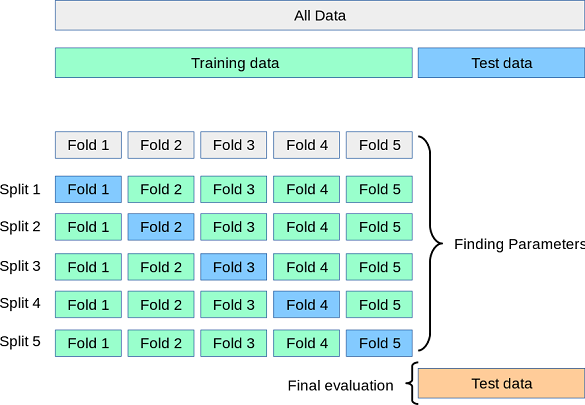



In [425]:
def print_tree(node, markerStr="+- ", levelMarkers=[]):
    level = len(levelMarkers)
    emptyStr = " " * 15
    connectionStr = "|" + emptyStr[:-4]
    mapper = lambda draw: connectionStr if draw else emptyStr
    markers = "".join(map(mapper, levelMarkers[:-1]))
    markers += markerStr if level > 0 else ""

    if isinstance(node, Leaf):
        print(f"{markers}Prediction ({ground_truth_label}): {node.predictions}")
        return

    print(f"{markers}{node.question}")
    if (node.question.partition_type == "discrete"):
        for i, child in enumerate(node.child_branches):
            label_answer = "("+ str(node.question.partition_values[i])+ ") -- "
            isLast = i==len(node.child_branches)-1
            print_tree(child, 
                      label_answer, [*levelMarkers, not isLast])

    else:  
        for i, child in enumerate(node.child_branches):
            if(i==0):
                range_answer = "("+ " ," + format(node.question.partition_values[i], '.2f') + ") -- "
            elif(i==len(node.child_branches)-1):
                range_answer = "["+ format(node.question.partition_values[i-1], '.2f') + ", ) -- "
            else:
                range_answer = "["+ format(node.question.partition_values[i-1], '.2f') + "," + format(node.question.partition_values[i], '.2f') + ") -- "
            
            isLast = i==len(node.child_branches)-1
            print_tree(child, 
                      range_answer, [*levelMarkers, not isLast])

# Error Analysis for Classification

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=24, shuffle=True)
import time

scores_array=[]
for max_depth in range(2,7):
    row = []
    print("max_depth : " + str(max_depth))
    i = 1

    test_F_scores, test_accuracies, test_ps, test_rs = [], [], [], []
    train_F_scores, train_accuracies, train_ps, train_rs = [], [], [], []

    start = time.time()
    for train_index, test_index in kf.split(X):  # Each FOLD

        print("   fold" + str(i) +  " :    " , end=" ")
        i += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        model = Decision_Tree(max_depth)
        model.train(X_train, y_train)

        train_acc, train_f, train_p, train_r = model.test(X_train,y_train)
        print("Train : F1 Score: {:.3f}, Accuracy: {:.3f}     ".format(train_f, train_acc), end="")

        test_acc, test_f, test_p, test_r = model.test(X_test, y_test)

        test_accuracies.append(test_acc)
        test_F_scores.append(test_f)
        test_ps.append(test_p)
        test_rs.append(test_r)

        train_accuracies.append(train_acc)
        train_F_scores.append(train_f)
        train_ps.append(train_p)
        train_rs.append(train_r)
        print(" TEST : F1 Score: {:.3f} ,  Accuracy: {:.3f} ".format(test_f, test_acc))

    print("   AVERAGE :                                                      F1 Score: {:.4f} ,  Accuracy: {:.4f} ".format(sum(test_F_scores)/5, sum(test_accuracies)/5))

    row.extend([max_depth, sum(train_F_scores)/5, sum(test_F_scores)/5, sum(train_accuracies)/5, sum(test_accuracies)/5, 
                sum(train_ps)/5, sum(test_ps)/5, sum(train_rs)/5, sum(test_rs)/5
    ])
    scores_array.append(row)
    finish = time.time()
    seconds = finish-start
    minutes = seconds//60
    seconds -= 60*minutes
    print('Elapsed time: %d:%d   minutes:seconds \n' %(minutes,seconds))

scores_df = pd.DataFrame(scores_array, columns=['max_depth', 'train_f1', 'test_f1','train_accuracy', 'test_accuracy',
                                                'train_precision', 'test_precision','train_recall','test_recall'
                                                ])

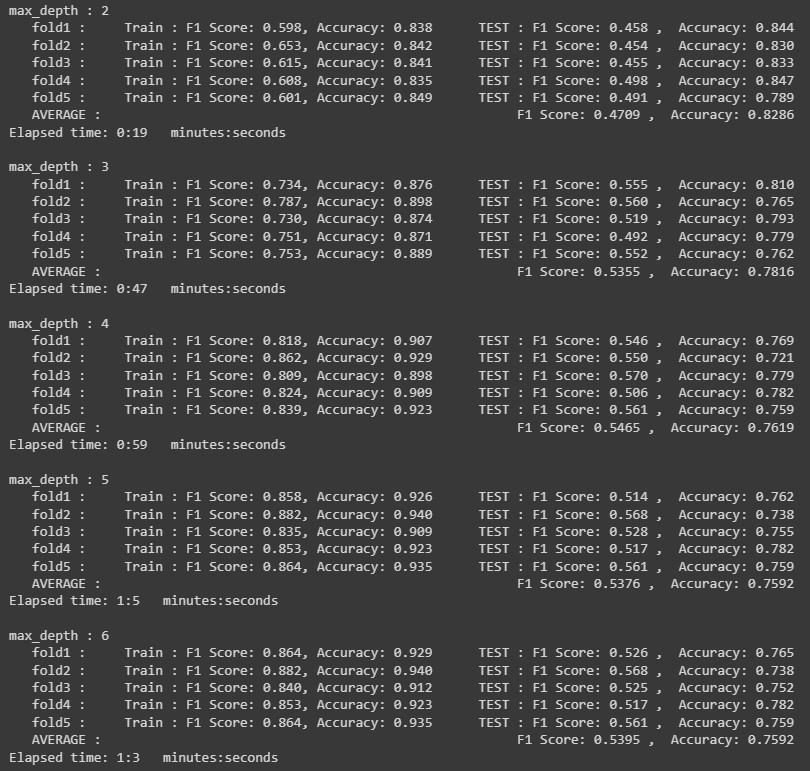

_It takes 4-5mins at average average to get results_

Because the dataset is skewed, you shouldn't rely too much on accuracy. So we will focus more on the f1 score.

As max_depth increases, model overfits the data. This can be seen from the increase of train classification performance, meanwhile the test performance decreases as max_dept increases. 

From the results above, it can be said that 2 is the best parameter for max_depth in this sense but since we will prune the decision tree later we cannot confidently say that the model will perform optimally with this parameter after pruning.

In [ ]:
scores_df

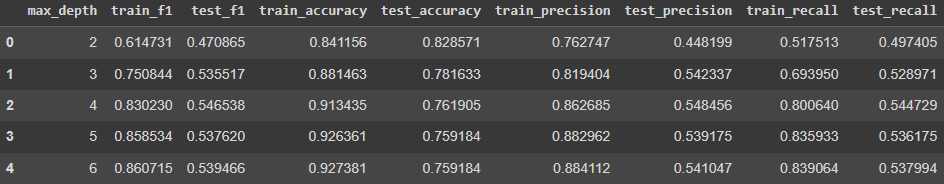

Attrition <br />
No:     1233 <br />
Yes:     237 <br />

If our model was predicting "No" for every row, we would get 0.8387 train/test accuracy.

# This is how overfit looks like 

Here is a visual representation of the trained decision tree model with max_depth as 6.

In [ ]:
kf = KFold(n_splits=5, random_state=24, shuffle=True)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        model = Decision_Tree(6)
        model.train(X_train, y_train)

        train_acc, train_f, train_p, train_r = model.test(X_train,y_train)
        print("Train : F1 Score: {:.3f}, Accuracy: {:.3f}     ".format(train_f, train_acc), end="")

        test_acc, test_f, test_p, test_r = model.test(X_test, y_test)
        print(" TEST : F1 Score: {:.3f} ,  Accuracy: {:.3f} ".format(test_f, test_acc))
        break
print_tree(model.root)

```
Train : F1 Score: 0.814, Accuracy: 0.908      TEST : F1 Score: 0.549 ,  Accuracy: 0.813 
which YearsWithCurrManager interval ?
( ,2.12) -- which YearsAtCompany interval ?
|           ( ,16.50) -- which YearsSinceLastPromotion interval ?
|           |           ( ,3.67) -- which MonthlyIncome interval ?
|           |           |           ( ,7253.33) -- which JobLevel interval ?
|           |           |           |           ( ,1.67) -- which DistanceFromHome interval ?
|           |           |           |           |           ( ,4.50) -- Prediction (Attrition): {'No': '86', 'Yes': '30'}
|           |           |           |           |           [4.50,8.00) -- Prediction (Attrition): {'No': '29', 'Yes': '14'}
|           |           |           |           |           [8.00,11.50) -- Prediction (Attrition): {'No': '42', 'Yes': '16'}
|           |           |           |           |           [11.50,15.00) -- Prediction (Attrition): {'No': '5', 'Yes': '4'}
|           |           |           |           |           [15.00,18.50) -- Prediction (Attrition): {'No': '10', 'Yes': '9'}
|           |           |           |           |           [18.50,22.00) -- Prediction (Attrition): {'No': '12', 'Yes': '4'}
|           |           |           |           |           [22.00,25.50) -- Prediction (Attrition): {'Yes': '11', 'No': '10'}
|           |           |           |           |           [25.50, ) -- Prediction (Attrition): {'No': '5'}
|           |           |           |           [1.67,2.33) -- which PercentSalaryHike interval ?
|           |           |           |           |           ( ,12.56) -- Prediction (Attrition): {'No': '41', 'Yes': '4'}
|           |           |           |           |           [12.56,14.11) -- Prediction (Attrition): {'No': '34', 'Yes': '6'}
|           |           |           |           |           [14.11,15.67) -- Prediction (Attrition): {'No': '11', 'Yes': '3'}
|           |           |           |           |           [15.67,17.22) -- Prediction (Attrition): {'No': '13', 'Yes': '2'}
|           |           |           |           |           [17.22,18.78) -- Prediction (Attrition): {'No': '6', 'Yes': '4'}
|           |           |           |           |           [18.78,20.33) -- Prediction (Attrition): {'No': '12'}
|           |           |           |           |           [20.33,21.89) -- Prediction (Attrition): {'No': '4'}
|           |           |           |           |           [21.89,23.44) -- Prediction (Attrition): {'No': '5'}
|           |           |           |           |           [23.44, ) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           [2.33, ) -- Prediction (Attrition): {'No': '2'}
|           |           |           [7253.33,13455.67) -- which TrainingTimesLastYear interval ?
|           |           |           |           ( ,0.86) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [0.86,1.71) -- Prediction (Attrition): {'No': '4'}
|           |           |           |           [1.71,2.57) -- which DistanceFromHome interval ?
|           |           |           |           |           ( ,4.43) -- Prediction (Attrition): {'No': '4'}
|           |           |           |           |           [4.43,7.86) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [7.86,11.29) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           |           [11.29,14.71) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [14.71,18.14) -- Prediction (Attrition): {'No': '2', 'Yes': '2'}
|           |           |           |           |           [18.14,21.57) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [21.57, ) -- Prediction (Attrition): {'Yes': '4'}
|           |           |           |           [2.57,3.43) -- which DailyRate interval ?
|           |           |           |           |           ( ,343.88) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           |           [343.88,494.75) -- Prediction (Attrition): {'Yes': '2'}
|           |           |           |           |           [494.75,645.62) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [645.62,796.50) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           |           [796.50,947.38) -- Prediction (Attrition): {'No': '5'}
|           |           |           |           |           [947.38,1098.25) -- Prediction (Attrition): {'No': '5'}
|           |           |           |           |           [1098.25,1249.12) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [1249.12, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [3.43,4.29) -- Prediction (Attrition): {'No': '4'}
|           |           |           |           [4.29,5.14) -- which StockOptionLevel interval ?
|           |           |           |           |           ( ,0.67) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           |           [0.67,1.33) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [1.33, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [5.14, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           [13455.67, ) -- Prediction (Attrition): {'No': '30'}
|           |           [3.67,7.33) -- which YearsInCurrentRole interval ?
|           |           |           ( ,3.43) -- Prediction (Attrition): {'No': '3'}
|           |           |           [3.43,4.86) -- Prediction (Attrition): {'No': '2'}
|           |           |           [4.86,6.29) -- Prediction (Attrition): {'No': '2'}
|           |           |           [6.29,7.71) -- Prediction (Attrition): {'No': '7'}
|           |           |           [7.71,9.14) -- Prediction (Attrition): {'No': '1'}
|           |           |           [9.14,10.57) -- Prediction (Attrition): {'No': '1'}
|           |           |           [10.57, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           [7.33, ) -- Prediction (Attrition): {'No': '4'}
|           [16.50, ) -- Prediction (Attrition): {'No': '4'}
[2.12,4.25) -- which YearsAtCompany interval ?
|           ( ,13.50) -- which YearsInCurrentRole interval ?
|           |           ( ,1.00) -- Prediction (Attrition): {'No': '6'}
|           |           [1.00,2.00) -- which HourlyRate interval ?
|           |           |           ( ,43.33) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [43.33,54.67) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [54.67,66.00) -- Prediction (Attrition): {'No': '2'}
|           |           |           [66.00,77.33) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [77.33,88.67) -- Prediction (Attrition): {'No': '2'}
|           |           |           [88.67, ) -- Prediction (Attrition): {'No': '2'}
|           |           [2.00,3.00) -- which TrainingTimesLastYear interval ?
|           |           |           ( ,0.86) -- Prediction (Attrition): {'No': '2'}
|           |           |           [0.86,1.71) -- Prediction (Attrition): {'No': '4'}
|           |           |           [1.71,2.57) -- which JobSatisfaction interval ?
|           |           |           |           ( ,1.75) -- Prediction (Attrition): {'Yes': '3'}
|           |           |           |           [1.75,2.50) -- which NumCompaniesWorked interval ?
|           |           |           |           |           ( ,3.00) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           |           [3.00,5.00) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           |           [5.00,7.00) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [7.00, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [2.50,3.25) -- Prediction (Attrition): {'No': '5'}
|           |           |           |           [3.25, ) -- Prediction (Attrition): {'No': '9'}
|           |           |           [2.57,3.43) -- which EmployeeNumber interval ?
|           |           |           |           ( ,442.22) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           [442.22,634.44) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [634.44,826.67) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [826.67,1018.89) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [1018.89,1211.11) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [1211.11,1403.33) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [1403.33,1595.56) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [1595.56,1787.78) -- which WorkLifeBalance interval ?
|           |           |           |           |           ( ,1.67) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           |           [1.67,2.33) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [2.33, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [1787.78, ) -- Prediction (Attrition): {'No': '3'}
|           |           |           [3.43,4.29) -- which NumCompaniesWorked interval ?
|           |           |           |           ( ,1.25) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [1.25,2.50) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [2.50,3.75) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           [3.75, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [4.29,5.14) -- which TotalWorkingYears interval ?
|           |           |           |           ( ,5.80) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [5.80,6.60) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [6.60,7.40) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [7.40,8.20) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [8.20, ) -- Prediction (Attrition): {'No': '2'}
|           |           |           [5.14, ) -- Prediction (Attrition): {'No': '1'}
|           |           [3.00,4.00) -- which TrainingTimesLastYear interval ?
|           |           |           ( ,0.86) -- Prediction (Attrition): {'No': '1'}
|           |           |           [0.86,1.71) -- Prediction (Attrition): {'No': '5'}
|           |           |           [1.71,2.57) -- which MonthlyRate interval ?
|           |           |           |           ( ,5890.50) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [5890.50,8573.00) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [8573.00,11255.50) -- which WorkLifeBalance interval ?
|           |           |           |           |           ( ,2.50) -- Prediction (Attrition): {'Yes': '2'}
|           |           |           |           |           [2.50, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [11255.50,13938.00) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [13938.00,16620.50) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [16620.50,19303.00) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [19303.00,21985.50) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [21985.50, ) -- Prediction (Attrition): {'No': '3'}
|           |           |           [2.57,3.43) -- Prediction (Attrition): {'No': '17'}
|           |           |           [3.43,4.29) -- which JobRole category ?
|           |           |           |           (Human Resources) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           (Laboratory Technician) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           (Manufacturing Director) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           (Sales Executive) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           (Sales Representative) -- Prediction (Attrition): {'Yes': '2'}
|           |           |           [4.29,5.14) -- Prediction (Attrition): {'No': '6'}
|           |           |           [5.14, ) -- Prediction (Attrition): {'No': '3'}
|           |           [4.00,5.00) -- which TrainingTimesLastYear interval ?
|           |           |           ( ,0.86) -- Prediction (Attrition): {'No': '2'}
|           |           |           [0.86,1.71) -- which WorkLifeBalance interval ?
|           |           |           |           ( ,1.67) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [1.67,2.33) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [2.33, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [1.71,2.57) -- which DailyRate interval ?
|           |           |           |           ( ,339.83) -- Prediction (Attrition): {'No': '5'}
|           |           |           |           [339.83,559.67) -- which YearsSinceLastPromotion interval ?
|           |           |           |           |           ( ,2.00) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           |           [2.00, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [559.67,779.50) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [779.50,999.33) -- which YearsSinceLastPromotion interval ?
|           |           |           |           |           ( ,0.50) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           |           [0.50, ) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           [999.33,1219.17) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [1219.17, ) -- Prediction (Attrition): {'No': '2'}
|           |           |           [2.57,3.43) -- Prediction (Attrition): {'No': '13'}
|           |           |           [3.43,4.29) -- Prediction (Attrition): {'No': '3'}
|           |           |           [4.29,5.14) -- Prediction (Attrition): {'No': '3'}
|           |           |           [5.14, ) -- Prediction (Attrition): {'No': '1'}
|           |           [5.00,6.00) -- Prediction (Attrition): {'No': '11'}
|           |           [6.00,7.00) -- Prediction (Attrition): {'No': '2'}
|           |           [7.00,8.00) -- which DailyRate interval ?
|           |           |           ( ,527.29) -- Prediction (Attrition): {'Yes': '2'}
|           |           |           [527.29,677.57) -- Prediction (Attrition): {'No': '1'}
|           |           |           [677.57,827.86) -- Prediction (Attrition): {'No': '1'}
|           |           |           [827.86,978.14) -- which YearsSinceLastPromotion interval ?
|           |           |           |           ( ,3.50) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [3.50, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [978.14,1128.43) -- Prediction (Attrition): {'No': '1'}
|           |           |           [1128.43,1278.71) -- Prediction (Attrition): {'No': '1'}
|           |           |           [1278.71, ) -- Prediction (Attrition): {'No': '1'}
|           |           [8.00, ) -- Prediction (Attrition): {'No': '6'}
|           [13.50, ) -- Prediction (Attrition): {'No': '3'}
[4.25,6.38) -- which YearsSinceLastPromotion interval ?
|           ( ,1.62) -- which DailyRate interval ?
|           |           ( ,398.33) -- Prediction (Attrition): {'No': '2'}
|           |           [398.33,592.67) -- Prediction (Attrition): {'No': '1'}
|           |           [592.67,787.00) -- which PerformanceRating interval ?
|           |           |           ( ,3.50) -- Prediction (Attrition): {'No': '8'}
|           |           |           [3.50, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           [787.00,981.33) -- Prediction (Attrition): {'No': '7'}
|           |           [981.33,1175.67) -- which WorkLifeBalance interval ?
|           |           |           ( ,1.67) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [1.67,2.33) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [2.33, ) -- Prediction (Attrition): {'No': '2'}
|           |           [1175.67, ) -- Prediction (Attrition): {'No': '1'}
|           [1.62,3.25) -- which YearsAtCompany interval ?
|           |           ( ,13.50) -- Prediction (Attrition): {'No': '3'}
|           |           [13.50, ) -- Prediction (Attrition): {'Yes': '1'}
|           [3.25,4.88) -- Prediction (Attrition): {'No': '2'}
|           [4.88,6.50) -- which YearsInCurrentRole interval ?
|           |           ( ,12.00) -- Prediction (Attrition): {'Yes': '1'}
|           |           [12.00, ) -- Prediction (Attrition): {'No': '1'}
|           [6.50,8.12) -- Prediction (Attrition): {'No': '8'}
|           [8.12,9.75) -- Prediction (Attrition): {'No': '3'}
|           [9.75,11.38) -- Prediction (Attrition): {'No': '1'}
|           [11.38, ) -- Prediction (Attrition): {'No': '1'}
[6.38,8.50) -- which YearsInCurrentRole interval ?
|           ( ,1.89) -- which NumCompaniesWorked interval ?
|           |           ( ,0.88) -- Prediction (Attrition): {'No': '2'}
|           |           [0.88,1.75) -- Prediction (Attrition): {'No': '8'}
|           |           [1.75,2.62) -- Prediction (Attrition): {'No': '2'}
|           |           [2.62,3.50) -- Prediction (Attrition): {'No': '1'}
|           |           [3.50,4.38) -- which YearsSinceLastPromotion interval ?
|           |           |           ( ,0.50) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [0.50, ) -- Prediction (Attrition): {'No': '1'}
|           |           [4.38,5.25) -- Prediction (Attrition): {'Yes': '1'}
|           |           [5.25,6.12) -- Prediction (Attrition): {'No': '1'}
|           |           [6.12, ) -- Prediction (Attrition): {'No': '1'}
|           [1.89,3.78) -- which NumCompaniesWorked interval ?
|           |           ( ,0.86) -- Prediction (Attrition): {'No': '4'}
|           |           [0.86,1.71) -- which JobRole category ?
|           |           |           (Healthcare Representative) -- Prediction (Attrition): {'No': '1'}
|           |           |           (Laboratory Technician) -- Prediction (Attrition): {'No': '1'}
|           |           |           (Manufacturing Director) -- Prediction (Attrition): {'Yes': '2'}
|           |           |           (Research Director) -- Prediction (Attrition): {'No': '1'}
|           |           |           (Research Scientist) -- Prediction (Attrition): {'Yes': '4'}
|           |           |           (Sales Executive) -- Prediction (Attrition): {'No': '1'}
|           |           [1.71,2.57) -- Prediction (Attrition): {'Yes': '1'}
|           |           [2.57,3.43) -- Prediction (Attrition): {'No': '2'}
|           |           [3.43,4.29) -- Prediction (Attrition): {'No': '1'}
|           |           [4.29,5.14) -- Prediction (Attrition): {'No': '1'}
|           |           [5.14, ) -- Prediction (Attrition): {'No': '1'}
|           [3.78,5.67) -- Prediction (Attrition): {'No': '10'}
|           [5.67,7.56) -- which YearsSinceLastPromotion interval ?
|           |           ( ,2.33) -- which NumCompaniesWorked interval ?
|           |           |           ( ,0.89) -- Prediction (Attrition): {'No': '11'}
|           |           |           [0.89,1.78) -- which DailyRate interval ?
|           |           |           |           ( ,300.38) -- Prediction (Attrition): {'No': '4'}
|           |           |           |           [300.38,456.75) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [456.75,613.12) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [613.12,769.50) -- which TrainingTimesLastYear interval ?
|           |           |           |           |           ( ,3.00) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           |           [3.00, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [769.50,925.88) -- which YearsAtCompany interval ?
|           |           |           |           |           ( ,7.75) -- Prediction (Attrition): {'No': '3'}
|           |           |           |           |           [7.75,8.50) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           |           [8.50,9.25) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [9.25, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [925.88,1082.25) -- Prediction (Attrition): {'No': '6'}
|           |           |           |           [1082.25,1238.62) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [1238.62, ) -- Prediction (Attrition): {'No': '5'}
|           |           |           [1.78,2.67) -- Prediction (Attrition): {'No': '7'}
|           |           |           [2.67,3.56) -- Prediction (Attrition): {'No': '12'}
|           |           |           [3.56,4.44) -- Prediction (Attrition): {'No': '6'}
|           |           |           [4.44,5.33) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [5.33,6.22) -- which YearsAtCompany interval ?
|           |           |           |           ( ,8.50) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [8.50, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [6.22,7.11) -- Prediction (Attrition): {'No': '1'}
|           |           |           [7.11, ) -- Prediction (Attrition): {'No': '3'}
|           |           [2.33,4.67) -- which DailyRate interval ?
|           |           |           ( ,395.71) -- Prediction (Attrition): {'Yes': '2'}
|           |           |           [395.71,530.43) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [530.43,665.14) -- which YearsAtCompany interval ?
|           |           |           |           ( ,7.50) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [7.50, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           [665.14,799.86) -- Prediction (Attrition): {'No': '2'}
|           |           |           [799.86,934.57) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [934.57,1069.29) -- Prediction (Attrition): {'No': '1'}
|           |           |           [1069.29, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           [4.67,7.00) -- Prediction (Attrition): {'No': '13'}
|           |           [7.00,9.33) -- which Education interval ?
|           |           |           ( ,1.80) -- Prediction (Attrition): {'Yes': '2'}
|           |           |           [1.80,2.60) -- which StockOptionLevel interval ?
|           |           |           |           ( ,0.67) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           [0.67,1.33) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [1.33, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [2.60,3.40) -- which MonthlyRate interval ?
|           |           |           |           ( ,6397.38) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [6397.38,8559.75) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [8559.75,10722.12) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [10722.12,12884.50) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [12884.50,15046.88) -- which YearsAtCompany interval ?
|           |           |           |           |           ( ,8.50) -- Prediction (Attrition): {'No': '2'}
|           |           |           |           |           [8.50, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [15046.88,17209.25) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [17209.25,19371.62) -- which TrainingTimesLastYear interval ?
|           |           |           |           |           ( ,0.75) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [0.75,1.50) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           |           [1.50,2.25) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           |           [2.25, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [19371.62, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [3.40,4.20) -- which YearsAtCompany interval ?
|           |           |           |           ( ,8.00) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [8.00,9.00) -- Prediction (Attrition): {'No': '1'}
|           |           |           |           [9.00, ) -- Prediction (Attrition): {'No': '1'}
|           |           |           [4.20, ) -- Prediction (Attrition): {'No': '2'}
|           |           [9.33,11.67) -- Prediction (Attrition): {'No': '2'}
|           |           [11.67, ) -- Prediction (Attrition): {'No': '4'}
|           [7.56,9.44) -- which YearsSinceLastPromotion interval ?
|           |           ( ,1.71) -- Prediction (Attrition): {'No': '17'}
|           |           [1.71,3.43) -- Prediction (Attrition): {'No': '11'}
|           |           [3.43,5.14) -- which MonthlyIncome interval ?
|           |           |           ( ,4883.43) -- Prediction (Attrition): {'No': '4'}
|           |           |           [4883.43,6973.86) -- Prediction (Attrition): {'No': '4'}
|           |           |           [6973.86,9064.29) -- which RelationshipSatisfaction interval ?
|           |           |           |           ( ,2.50) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           |           [2.50, ) -- Prediction (Attrition): {'No': '4'}
|           |           |           [9064.29,11154.71) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [11154.71,13245.14) -- Prediction (Attrition): {'No': '1'}
|           |           |           [13245.14,15335.57) -- Prediction (Attrition): {'No': '1'}
|           |           |           [15335.57, ) -- Prediction (Attrition): {'No': '1'}
|           |           [5.14,6.86) -- which WorkLifeBalance interval ?
|           |           |           ( ,2.50) -- Prediction (Attrition): {'No': '1'}
|           |           |           [2.50, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           [6.86,8.57) -- which WorkLifeBalance interval ?
|           |           |           ( ,2.67) -- Prediction (Attrition): {'No': '4'}
|           |           |           [2.67,3.33) -- Prediction (Attrition): {'No': '9'}
|           |           |           [3.33, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           [8.57,10.29) -- which TotalWorkingYears interval ?
|           |           |           ( ,11.33) -- Prediction (Attrition): {'Yes': '1'}
|           |           |           [11.33,12.67) -- Prediction (Attrition): {'No': '1'}
|           |           |           [12.67, ) -- Prediction (Attrition): {'Yes': '2'}
|           |           [10.29, ) -- Prediction (Attrition): {'No': '2'}
|           [9.44,11.33) -- Prediction (Attrition): {'No': '14'}
|           [11.33,13.22) -- Prediction (Attrition): {'No': '5'}
|           [13.22,15.11) -- which YearsSinceLastPromotion interval ?
|           |           ( ,10.00) -- Prediction (Attrition): {'No': '1'}
|           |           [10.00, ) -- Prediction (Attrition): {'Yes': '2'}
|           [15.11, ) -- Prediction (Attrition): {'No': '3'}
[8.50,10.62) -- which YearsInCurrentRole interval ?
|           ( ,2.00) -- Prediction (Attrition): {'No': '3'}
|           [2.00,4.00) -- Prediction (Attrition): {'No': '2'}
|           [4.00,6.00) -- which WorkLifeBalance interval ?
|           |           ( ,1.67) -- Prediction (Attrition): {'Yes': '1'}
|           |           [1.67,2.33) -- Prediction (Attrition): {'Yes': '1'}
|           |           [2.33, ) -- Prediction (Attrition): {'No': '1'}
|           [6.00,8.00) -- which MonthlyRate interval ?
|           |           ( ,6161.62) -- Prediction (Attrition): {'No': '4'}
|           |           [6161.62,8774.25) -- Prediction (Attrition): {'No': '1'}
|           |           [8774.25,11386.88) -- Prediction (Attrition): {'No': '3'}
|           |           [11386.88,13999.50) -- Prediction (Attrition): {'Yes': '1'}
|           |           [13999.50,16612.12) -- Prediction (Attrition): {'No': '2'}
|           |           [16612.12,19224.75) -- Prediction (Attrition): {'No': '2'}
|           |           [19224.75,21837.38) -- Prediction (Attrition): {'No': '2'}
|           |           [21837.38, ) -- Prediction (Attrition): {'No': '2'}
|           [8.00,10.00) -- which TotalWorkingYears interval ?
|           |           ( ,13.71) -- Prediction (Attrition): {'No': '9'}
|           |           [13.71,17.43) -- which YearsSinceLastPromotion interval ?
|           |           |           ( ,6.50) -- Prediction (Attrition): {'No': '3'}
|           |           |           [6.50, ) -- Prediction (Attrition): {'Yes': '1'}
|           |           [17.43,21.14) -- Prediction (Attrition): {'No': '5'}
|           |           [21.14,24.86) -- Prediction (Attrition): {'No': '2'}
|           |           [24.86,28.57) -- Prediction (Attrition): {'No': '1'}
|           |           [28.57,32.29) -- Prediction (Attrition): {'Yes': '1'}
|           |           [32.29, ) -- Prediction (Attrition): {'No': '3'}
|           [10.00,12.00) -- Prediction (Attrition): {'No': '8'}
|           [12.00,14.00) -- Prediction (Attrition): {'No': '2'}
|           [14.00,16.00) -- Prediction (Attrition): {'No': '1'}
|           [16.00, ) -- Prediction (Attrition): {'No': '4'}
[10.62,12.75) -- which EmployeeNumber interval ?
|           ( ,251.11) -- Prediction (Attrition): {'No': '5'}
|           [251.11,474.22) -- Prediction (Attrition): {'No': '1'}
|           [474.22,697.33) -- Prediction (Attrition): {'No': '3'}
|           [697.33,920.44) -- Prediction (Attrition): {'No': '3'}
|           [920.44,1143.56) -- Prediction (Attrition): {'No': '6'}
|           [1143.56,1366.67) -- which YearsSinceLastPromotion interval ?
|           |           ( ,3.00) -- Prediction (Attrition): {'Yes': '1'}
|           |           [3.00, ) -- Prediction (Attrition): {'No': '2'}
|           [1366.67,1589.78) -- Prediction (Attrition): {'No': '2'}
|           [1589.78,1812.89) -- Prediction (Attrition): {'No': '5'}
|           [1812.89, ) -- Prediction (Attrition): {'No': '4'}
[12.75,14.88) -- which EnvironmentSatisfaction interval ?
|           ( ,1.75) -- Prediction (Attrition): {'No': '2'}
|           [1.75,2.50) -- Prediction (Attrition): {'No': '7'}
|           [2.50,3.25) -- Prediction (Attrition): {'Yes': '2'}
|           [3.25, ) -- Prediction (Attrition): {'No': '3'}
[14.88, ) -- Prediction (Attrition): {'No': '11'}
```



# This is how the best performed model looks like

In [ ]:
kf = KFold(n_splits=5, random_state=24, shuffle=True)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        model = Decision_Tree(2)
        model.train(X_train, y_train)

        train_acc, train_f, train_p, train_r = model.test(X_train,y_train)
        print("Train : F1 Score: {:.3f}, Accuracy: {:.3f}     ".format(train_f, train_acc), end="")

        test_acc, test_f, test_p, test_r = model.test(X_test, y_test)
        print(" TEST : F1 Score: {:.3f} ,  Accuracy: {:.3f} ".format(test_f, test_acc))
        break
print_tree(model.root)



```
Train : F1 Score: 0.625, Accuracy: 0.840      TEST : F1 Score: 0.453 ,  Accuracy: 0.827 
which YearsWithCurrManager interval ?
( ,2.12) -- which YearsAtCompany interval ?
|           ( ,16.50) -- Prediction (Attrition): {'No': '421', 'Yes': '118'}
|           [16.50, ) -- Prediction (Attrition): {'No': '4'}
[2.12,4.25) -- which YearsAtCompany interval ?
|           ( ,13.50) -- Prediction (Attrition): {'No': '172', 'Yes': '25'}
|           [13.50, ) -- Prediction (Attrition): {'No': '3'}
[4.25,6.38) -- which YearsSinceLastPromotion interval ?
|           ( ,1.62) -- Prediction (Attrition): {'No': '21', 'Yes': '3'}
|           [1.62,3.25) -- Prediction (Attrition): {'No': '3', 'Yes': '1'}
|           [3.25,4.88) -- Prediction (Attrition): {'No': '2'}
|           [4.88,6.50) -- Prediction (Attrition): {'Yes': '1', 'No': '1'}
|           [6.50,8.12) -- Prediction (Attrition): {'No': '8'}
|           [8.12,9.75) -- Prediction (Attrition): {'No': '3'}
|           [9.75,11.38) -- Prediction (Attrition): {'No': '1'}
|           [11.38, ) -- Prediction (Attrition): {'No': '1'}
[6.38,8.50) -- which YearsInCurrentRole interval ?
|           ( ,1.89) -- Prediction (Attrition): {'No': '16', 'Yes': '2'}
|           [1.89,3.78) -- Prediction (Attrition): {'No': '13', 'Yes': '7'}
|           [3.78,5.67) -- Prediction (Attrition): {'No': '10'}
|           [5.67,7.56) -- Prediction (Attrition): {'No': '108', 'Yes': '18'}
|           [7.56,9.44) -- Prediction (Attrition): {'No': '60', 'Yes': '7'}
|           [9.44,11.33) -- Prediction (Attrition): {'No': '14'}
|           [11.33,13.22) -- Prediction (Attrition): {'No': '5'}
|           [13.22,15.11) -- Prediction (Attrition): {'Yes': '2', 'No': '1'}
|           [15.11, ) -- Prediction (Attrition): {'No': '3'}
[8.50,10.62) -- which YearsInCurrentRole interval ?
|           ( ,2.00) -- Prediction (Attrition): {'No': '3'}
|           [2.00,4.00) -- Prediction (Attrition): {'No': '2'}
|           [4.00,6.00) -- Prediction (Attrition): {'Yes': '2', 'No': '1'}
|           [6.00,8.00) -- Prediction (Attrition): {'No': '16', 'Yes': '1'}
|           [8.00,10.00) -- Prediction (Attrition): {'No': '23', 'Yes': '2'}
|           [10.00,12.00) -- Prediction (Attrition): {'No': '8'}
|           [12.00,14.00) -- Prediction (Attrition): {'No': '2'}
|           [14.00,16.00) -- Prediction (Attrition): {'No': '1'}
|           [16.00, ) -- Prediction (Attrition): {'No': '4'}
[10.62,12.75) -- which EmployeeNumber interval ?
|           ( ,251.11) -- Prediction (Attrition): {'No': '5'}
|           [251.11,474.22) -- Prediction (Attrition): {'No': '1'}
|           [474.22,697.33) -- Prediction (Attrition): {'No': '3'}
|           [697.33,920.44) -- Prediction (Attrition): {'No': '3'}
|           [920.44,1143.56) -- Prediction (Attrition): {'No': '6'}
|           [1143.56,1366.67) -- Prediction (Attrition): {'No': '2', 'Yes': '1'}
|           [1366.67,1589.78) -- Prediction (Attrition): {'No': '2'}
|           [1589.78,1812.89) -- Prediction (Attrition): {'No': '5'}
|           [1812.89, ) -- Prediction (Attrition): {'No': '4'}
[12.75,14.88) -- which EnvironmentSatisfaction interval ?
|           ( ,1.75) -- Prediction (Attrition): {'No': '2'}
|           [1.75,2.50) -- Prediction (Attrition): {'No': '7'}
|           [2.50,3.25) -- Prediction (Attrition): {'Yes': '2'}
|           [3.25, ) -- Prediction (Attrition): {'No': '3'}
[14.88, ) -- Prediction (Attrition): {'No': '11'}
```



# Comments on few misclassifications

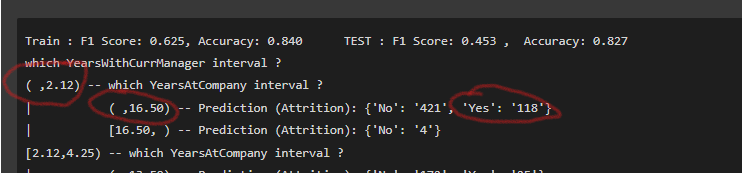

In [440]:
df_misclassified = df[(df['YearsWithCurrManager']<2.12) & (df['YearsAtCompany']<16.50) & (df['Attrition'] == 'Yes')]

#reordering columns
df_misclassified.insert(0, 'Attrition', df_misclassified.pop("Attrition"))
df_misclassified.insert(0, 'YearsWithCurrManager', df_misclassified.pop("YearsWithCurrManager"))
df_misclassified.insert(0, 'YearsAtCompany', df_misclassified.pop("YearsAtCompany"))

In [444]:
df_misclassified.iloc[[test_index[0]]]

,YearsAtCompany,YearsWithCurrManager,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
33,1,0,Yes,39,Travel_Rarely,895,Sales,5,3,Technical Degree,1,42,4,Male,56,3,2,Sales Representative,4,Married,2086,3335,3,Y,No,14,3,3,80,1,19,6,4,0,0


Model is underfitted to the dataset. Because this leaf node has big entropy, even bigger entropy than the inital entropy of the whole dataset. Thus, the model probably is available for further information gains if more depth was used and if the tree was pruned after.

In [445]:
df_misclassified.iloc[[test_index[15]]]

,YearsAtCompany,YearsWithCurrManager,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
669,2,2,Yes,39,Travel_Rarely,1122,Research & Development,6,3,Medical,1,932,4,Male,70,3,1,Laboratory Technician,1,Married,2404,4303,7,Y,Yes,21,4,4,80,0,8,2,1,2,2


# Assignment 2: PART 2 :  Pruning Decision Tree

## Decision Tree Pruning
Pruning is a data compression technique in machine learning and search algorithms that reduces the size of decision trees by removing sections of the tree that are non-critical and redundant to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.

One of the questions that arises in a decision tree algorithm is the optimal size of the final tree. A tree that is too large risks overfitting the training data and poorly generalizing to new samples. A small tree might not capture important structural information about the sample space. However, it is hard to tell when a tree algorithm should stop because it is impossible to tell if the addition of a single extra node will dramatically decrease error. This problem is known as the horizon effect. A common strategy is to grow the tree until each node contains a small number of instances then use pruning to remove nodes that do not provide additional information.


Things to consider below.
We are np.mean(precision)
it means, average precision of representing each ground truth class

dataset has 1240 No, 210 Yes. Hmmm 🤔

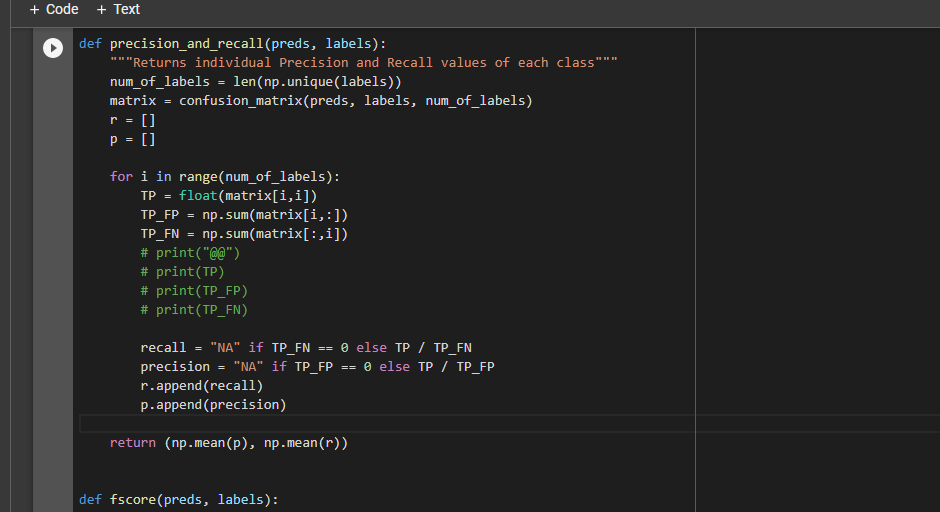

##Pruning

Because of the nature of training decision trees they can be prone to major overfitting. Setting the correct value for minimum number of instances per node can be challenging. Most of the time, we might just go with a safe bet and make that minimum quite small, resulting in there being many splits and a very large, complex tree. The key is that many of these splits will end up being redundant and unnecessary to increasing the accuracy of our model.

Tree pruning is a technique that leverages this splitting redundancy to remove i.e prune the unnecessary splits in our tree. From a high-level, pruning compresses part of the tree from strict and rigid decision boundaries into ones that are more smooth and generalise better, effectively reducing the tree complexity. The complexity of a decision tree is defined as the number of splits in the tree.

A simple yet highly effective pruning method is to go through each node in the tree and evaluate the effect of removing it on the cost function. If it doesn’t change much, then prune away!

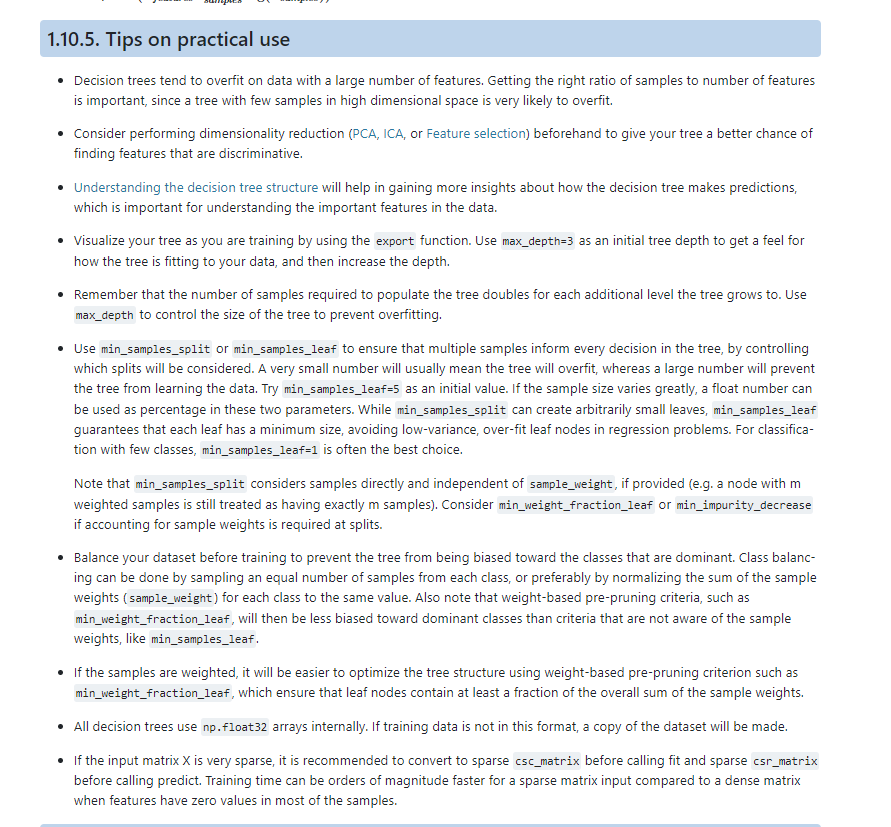